In [87]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [50]:
dataset, info = tfds.load('glue/sst2', with_info = True)
print(info.features)
print(info.features['label'].num_classes)
print(info.features['label'].names)

FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})
2
['negative', 'positive']


In [51]:
dataset_train, dataset_val = dataset['train'], dataset['validation']
dataset_train

<_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [52]:
for example in dataset_train.take(2):
    review, label = example['sentence'], example['label']
    print('Review: ', review)
    print('Label: %d \n' % label.numpy())

Review:  tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review:  tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [53]:
train_reviews = []
train_labels = []

val_reviews = []
val_labels = []

for item in dataset_train.take(10000):
    review, label = item['sentence'], item['label']
    train_reviews.append(str(review.numpy()))
    train_labels.append(label.numpy())

print("\nNumber of training reviews is: ", len(train_reviews))

for i in range(0, 2):
        print(train_reviews[i])
        print(train_labels[i])

for item in dataset_val.take(-1):
        review, label = item['sentence'], item['label']
        val_reviews.append(str(review.numpy()))
        val_labels.append(label.numpy())

print("\nNumber of validation reviews is: ",len(val_reviews))

for i in range(0, 2):
        print(val_reviews[i])
        print(val_labels[i])


Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


In [54]:
vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type = 'post'
pad_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index

In [55]:
train_seq = tokenizer.texts_to_sequences(train_reviews)
train_padded = pad_sequences(train_seq, maxlen = max_length, padding = pad_type,
                             truncating = trunc_type)

val_seq = tokenizer.texts_to_sequences(val_reviews)
val_padded = pad_sequences(val_seq, maxlen = max_length, padding = pad_type,
                           truncating = trunc_type)

train_label_fin = np.array(train_labels)
test_label_fin = np.array(val_labels)

In [56]:
def fit_models_and_show_results(model, reviews):
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    model.summary()
    
    history = model.fit(train_padded, train_label_fin, epochs = 30, 
                        validation_data = (val_padded, test_label_fin))

    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

In [57]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [66]:
def predict_reviews(model, review):
    pad_type = 'post'
    sample_seq = tokenizer.texts_to_sequences(review)
    reviews_padded = pad_sequences(sample_seq, maxlen = max_length, padding = pad_type)

    classes = model.predict(reviews_padded)
    for x in range(len(reviews_padded)):
        print(review[x])
        print(classes[x])
        print("\n")

Embedding

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [60]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()
    
history = model.fit(train_padded, train_label_fin, epochs = 30, 
                        validation_data = (val_padded, test_label_fin))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d_3  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 64017 (250.07 KB)
Trainable params: 64017 (250.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 1s 2ms/step - loss: 0.6840 - accuracy: 0.5567 - val_loss: 0.6889 - val_accuracy: 0.5138
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss

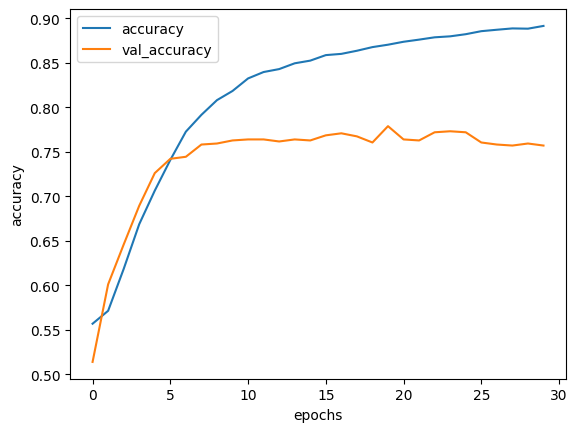

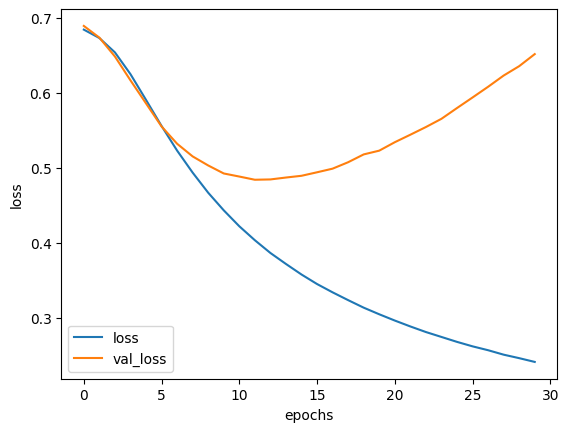

In [61]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [62]:
review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]

In [67]:
predict_reviews(model, new_reviews)

1/1 [==============================] - 0s 25ms/step
I loved this movie
[0.42876112]


that was the worst movie I've ever seen
[0.07922255]


too much violence even for a Bond film
[0.00451382]


a captivating recounting of a cherished myth
[0.74920034]




Convolutional Neural network

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65313 (255.13 KB)
Trainable params: 65313 (255.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 2s 3ms/step - loss: 0.6616 -

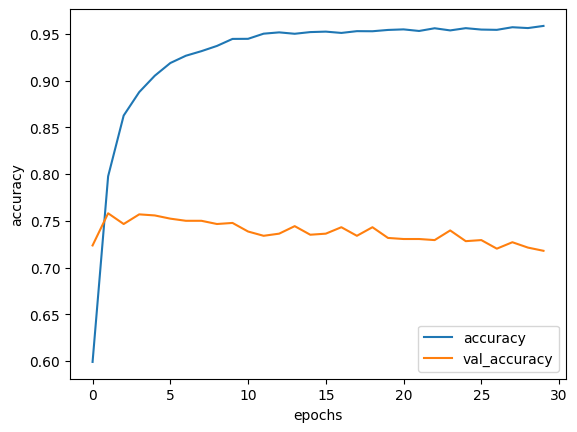

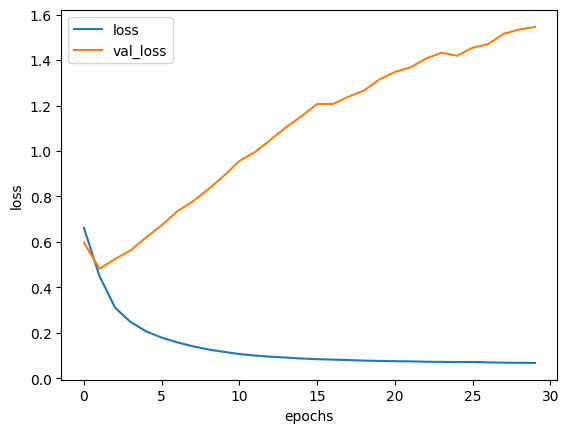

In [70]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_models_and_show_results(model_cnn, new_reviews)

GRU

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 73665 (287.75 KB)
Trainable params: 73665 (287.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 10s 21ms/step - loss: 2.4142 - accuracy: 0.5404 - val_loss: 0.5804 - val_accuracy: 0.6984
Epoch 2/30
313/313 [==============================] - 6s 20ms/step - l

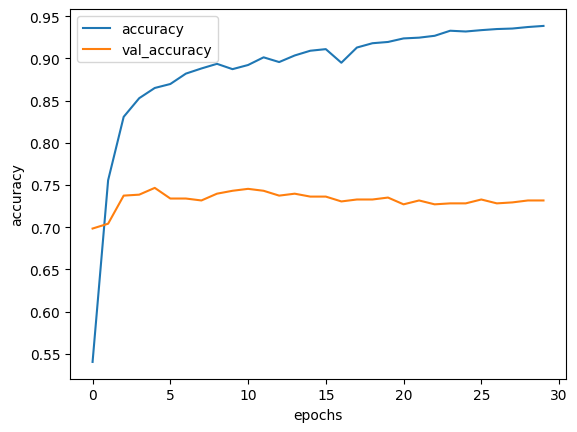

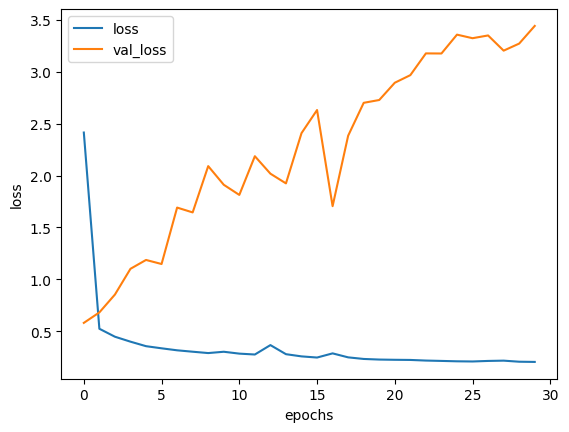

In [74]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation = 'relu')
])

fit_models_and_show_results(model_gru, new_reviews)

LSTM

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 16)            64000     
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                4224      
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68257 (266.63 KB)
Trainable params: 68257 (266.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 10s 19ms/step - loss: 0.6440 - accuracy: 0.6185 - val_loss: 0.5389 - val_accuracy: 0.7466
Epoch 2/30
313/313 [==============================] - 5s 16ms/step - l

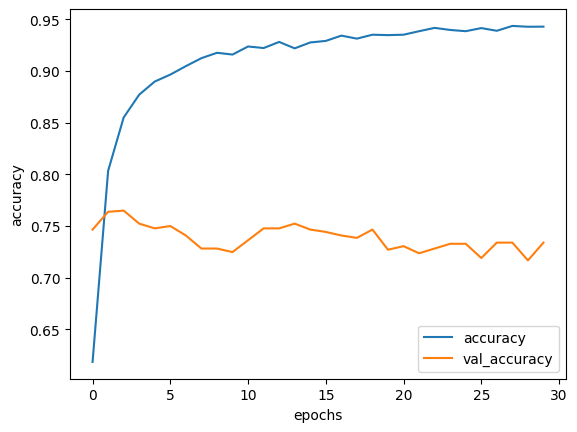

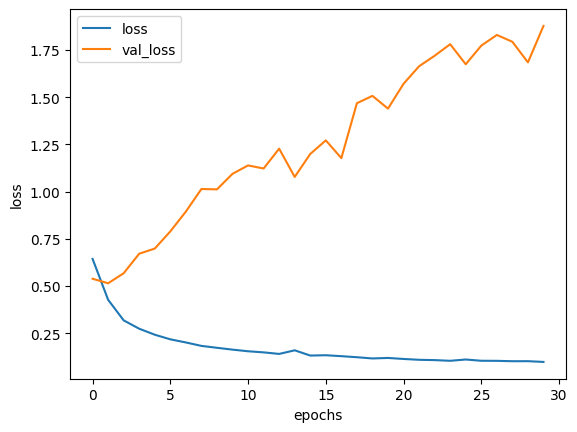

In [75]:
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_models_and_show_results(model_bidi_lstm, new_reviews)

Stacked LSTM

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 16)            64000     
                                                                 
 bidirectional_3 (Bidirecti  (None, 50, 32)            4224      
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 74529 (291.13 KB)
Trainable params: 74529 (291.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
313/

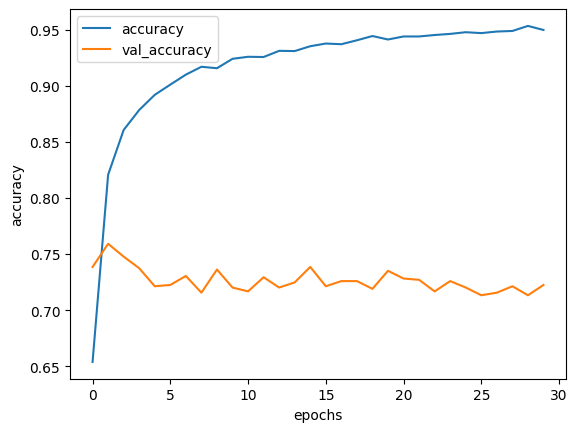

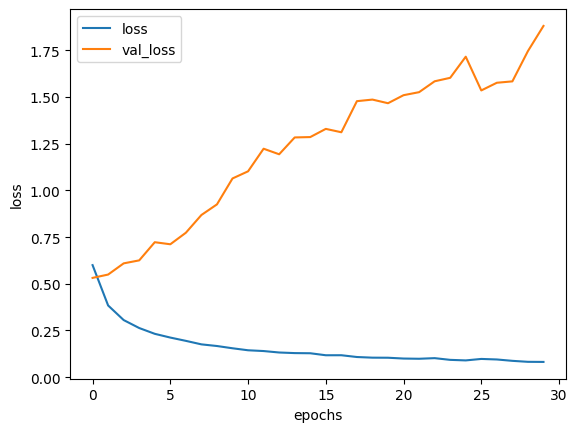

In [76]:
model_mul_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_models_and_show_results(model_mul_lstm, new_reviews)

In [77]:
review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]

In [79]:
print("============================\n","Embeddings only:\n", "============================")
predict_reviews(model, more_reviews)

 Embeddings only:
1/1 [==============================] - 0s 21ms/step
I loved this movie
[0.42876112]


that was the worst movie I've ever seen
[0.07922255]


too much violence even for a Bond film
[0.00451382]


a captivating recounting of a cherished myth
[0.74920034]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.38918018]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.72204036]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.4596388]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5598805]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappoint

In [80]:
print("============================\n","With CNN\n", "============================")
predict_reviews(model_cnn, more_reviews)

 With CNN
1/1 [==============================] - 0s 28ms/step
I loved this movie
[0.9984737]


that was the worst movie I've ever seen
[0.00011116]


too much violence even for a Bond film
[1.1113981e-09]


a captivating recounting of a cherished myth
[0.9993521]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.00477682]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9966841]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.60027045]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9997373]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in t

In [82]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_reviews(model_gru, more_reviews)

 With bidirectional GRU
1/1 [==============================] - 0s 28ms/step
I loved this movie
[0.86472225]


that was the worst movie I've ever seen
[0.]


too much violence even for a Bond film
[0.]


a captivating recounting of a cherished myth
[1.9164023]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[1.2987058]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[2.8965526]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[1.4647719]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 

In [83]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_reviews(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 [==============================] - 1s 700ms/step
I loved this movie
[0.76847]


that was the worst movie I've ever seen
[0.04399411]


too much violence even for a Bond film
[0.0014147]


a captivating recounting of a cherished myth
[0.9997652]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.99999726]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99937576]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.83283806]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9999889]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was v

In [88]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_reviews(model_mul_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 [==============================] - 0s 33ms/step
I loved this movie
[0.8239591]


that was the worst movie I've ever seen
[0.11337073]


too much violence even for a Bond film
[8.800643e-05]


a captivating recounting of a cherished myth
[0.99963695]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.99886274]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99875087]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.08803627]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9998021]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I 